# Notebook 11: Introduction to Deep Neural Networks with Keras

## Learning Goals
The goal of this notebook is to introduce deep neural networks (DNNs) using the high-level Keras package. The reader will become familiar with how to choose an architecture, cost function, and optimizer in Keras. We will also learn how to train neural networks.


# MNIST with Keras

We will once again work with the MNIST dataset of hand written digits introduced in *Notebook 7: Logistic Regression (MNIST)*. The goal is to find a statistical model which recognizes and distinguishes between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ nuances of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic classification task. 

In this Notebook, we show how to use the Keras python package to tackle the MNIST problem with the help of deep neural networks.

The following code is a slight modification of a Keras tutorial, see [https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py). We invite the reader to read Sec. IX of the review to acquire a broad understanding of what the separate parts of the code do.

In [3]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=0
np.random.seed(seed) # fix random seed
import matplotlib.pyplot as plt

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Mini project

We would like to emphasize that, while it is always possible to view steps 1-5 as independent of the particular task we are trying to solve, it is only when they are put together in ***step 6*** that the real gain of using Deep Learning is revealed, compared to less sophisticated methods such as the regression models or bagging, described in Secs. VII and VIII of the review. With this remark in mind, we shall focus predominantly on steps 1-5 below. We show how one can use grid search methods to find optimal hyperparameters in ***step 6***.

### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape. This differs from one package to the other and, as we see in the case of Keras, it can even be different depending on the backend used.

While choosing the correct `datatype` can help improve the computational speed, we emphasize the rescaling step, which is necessary to avoid large variations in the minimal and maximal possible values of each feature. In other words, we want to make sure a feature is not being over-represented just because it is "large".

Last, we cast the label vectors $y$ to binary class matrices (a.k.a. one-hot format), as explained in Sec. VII on SoftMax regression.

(60000, 28, 28)
(60000, 784)
an example of a data point with label 4


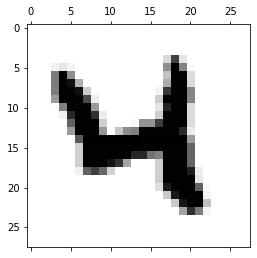

X_train shape: (60000, 784)
Y_train shape: (60000, 10)
60000 train samples
10000 test samples


In [4]:
from keras.datasets import mnist

# input image dimensions
num_classes = 10 # 10 digits

img_rows, img_cols = 28, 28 # number of pixels 

# the data, shuffled and split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(np.shape(X_train))
# reshape data, depending on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print(np.shape(X_train))
# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one.

At this stage, we refrain from using convolutional layers. This is done further below.

Let us create an instance of Keras' `Sequential()` class, called `model`. As the name suggests, this class allows us to build DNNs layer by layer. We use the `add()` method to attach layers to our model. For the purposes of our introductory example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use `Adam()` or any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [6]:
def compile_model(optimizer=keras.optimizers.Adam()):
    # create the mode
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


### Step 4: Train the model

We train our DNN in minibatches, the advantages of which were explained in Sec. IV. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. 

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [7]:
# training parameters
batch_size = 64
epochs = 10

# create the deep neural net
model_DNN=compile_model()

# train DNN and store training info in history
history=model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3115 - accuracy: 0.9093 - val_loss: 0.1129 - val_accuracy: 0.9641
Epoch 2/10
938/938 [==============================] - 5s 6ms/step - loss: 0.1249 - accuracy: 0.9639 - val_loss: 0.0858 - val_accuracy: 0.9727
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0873 - accuracy: 0.9737 - val_loss: 0.0758 - val_accuracy: 0.9773
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0681 - accuracy: 0.9799 - val_loss: 0.0724 - val_accuracy: 0.9772
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0544 - accuracy: 0.9832 - val_loss: 0.0746 - val_accuracy: 0.9781
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0440 - accuracy: 0.9866 - val_loss: 0.0728 - val_accuracy: 0.9798
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0381 - accuracy: 0.9880 - val_loss: 0.0733 - val_accuracy: 0.9789
Epoch 

Les batchs permettent une meilleur efficience (computationalement parlant) que la descente de gradient basique, et les mini batch evite les erreur de convergence exagéré qu'on peux avoir avec des batch de la taille du training set.

### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 [==============================] - 1s 2ms/step - loss: 0.0747 - accuracy: 0.9831

Test loss: 0.07469120621681213
Test accuracy: 0.9830999970436096


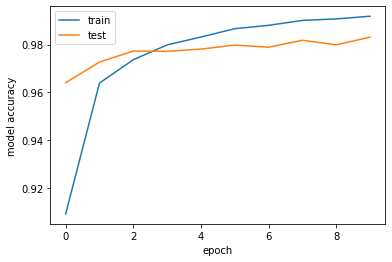

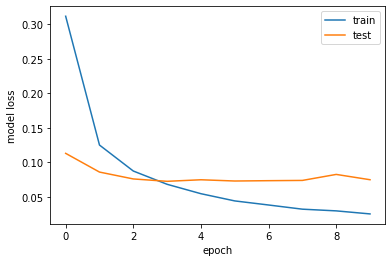

In [8]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Step 6: Mini project
Use what you've learnt above to reduce the test error as much as possible. You can study the effect of hyperparameters, the size of the training set, the solver you use, the number of neurons, of layers...

Let's create few new models with differents properties and compare them to the first one.
First let's redefine the function to make it easier to change the properties of our model:


In [9]:
def create_DNN(activation,density,intermediate_layers,dropout):
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400*density,input_shape=(img_rows*img_cols,), activation=activation))
    # add a dense all-to-all relu layer
    for i in range(intermediate_layers):
        model.add(Dense(100*density, activation=activation))
    # apply dropout with rate 0.5
    if dropout==1:
        model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model



def compile_model(loss,optimizer,activation,density,intermediate_layers,dropout):
    # create the mode
    model=create_DNN(activation,density,intermediate_layers,dropout)
    # compile the model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

The parameters we chose for the first model were: cross entropy as loss, the Adam optimizer, relu as activation function. It uses 3 layers, as well as a dropout layer. The first layer is made of 400 neurons, which takes in our mnist data. The second layer is an intermediate of 100 units. The last serves as an output, and as such have 10 units corresponding to each of the possible solutions. 

First, let's change the **loss function:**



In [54]:
model_MSE=compile_model(loss=keras.losses.MeanSquaredError(),
                        optimizer=keras.optimizers.Adam(),
                        activation='relu',
                        density=1,
                        intermediate_layers=1,
                        dropout=1)

history_MSE=model_crossentropy.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))



Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.2246 - val_accuracy: 0.9846
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.2194 - val_accuracy: 0.9845
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.2623 - val_accuracy: 0.9819
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.2158 - val_accuracy: 0.9829
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.2175 - val_accuracy: 0.9828
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.2220 - val_accuracy: 0.9837
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.2288 - val_accuracy: 0.9833
Epoch 

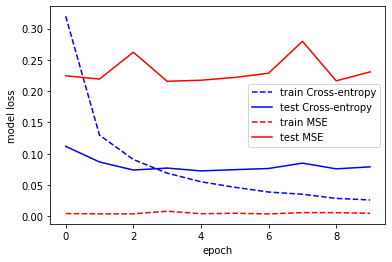

In [55]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'b')
plt.plot(history_MSE.history['loss'],'r--')
plt.plot(history_MSE.history['val_loss'],'r')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train Cross-entropy', 'test Cross-entropy','train MSE','test MSE'], loc='best')
plt.show()

**The optimizer:**

In [57]:
model_SGD=compile_model(loss=keras.losses.categorical_crossentropy,
                        optimizer=keras.optimizers.SGD(),
                        activation='relu',
                        density=1,
                        intermediate_layers=1,
                        dropout=1)

history_SGD=model_SGD.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))


Epoch 1/10
938/938 [==============================] - 4s 5ms/step - loss: 1.0536 - accuracy: 0.6874 - val_loss: 0.4237 - val_accuracy: 0.8925
Epoch 2/10
938/938 [==============================] - 10s 10ms/step - loss: 0.5042 - accuracy: 0.8561 - val_loss: 0.3111 - val_accuracy: 0.9116
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.4050 - accuracy: 0.8866 - val_loss: 0.2634 - val_accuracy: 0.9236
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3551 - accuracy: 0.9000 - val_loss: 0.2363 - val_accuracy: 0.9312
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3196 - accuracy: 0.9101 - val_loss: 0.2157 - val_accuracy: 0.9370
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2940 - accuracy: 0.9171 - val_loss: 0.1992 - val_accuracy: 0.9414
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2702 - accuracy: 0.9234 - val_loss: 0.1852 - val_accuracy: 0.9451
Epoc

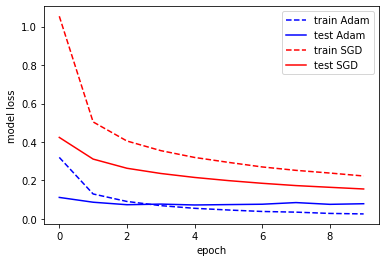

In [58]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'b')
plt.plot(history_SGD.history['loss'],'r--')
plt.plot(history_SGD.history['val_loss'],'r')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train Adam', 'test Adam','train SGD','test SGD'], loc='best')
plt.show()

On voit que la SGD classique est moins performante que Adam (ce qui est attendu)

**Activation function:**

In [10]:
model_sigmoid=compile_model(loss=keras.losses.categorical_crossentropy,
                            optimizer=keras.optimizers.Adam(),
                            activation='sigmoid',
                            density=1,
                            intermediate_layers=1,
                            dropout=1)

history_sigmoid=model_sigmoid.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

model_tanh=compile_model(loss=keras.losses.categorical_crossentropy,
                         optimizer=keras.optimizers.Adam(),
                         activation='tanh',
                         density=1,
                         intermediate_layers=1,
                         dropout=1)

history_tanh=model_tanh.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
938/938 [==============================] - 5s 6ms/step - loss: 0.6046 - accuracy: 0.8222 - val_loss: 0.2440 - val_accuracy: 0.9259
Epoch 2/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2636 - accuracy: 0.9247 - val_loss: 0.1766 - val_accuracy: 0.9454
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.1912 - accuracy: 0.9450 - val_loss: 0.1334 - val_accuracy: 0.9601
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1499 - accuracy: 0.9567 - val_loss: 0.1091 - val_accuracy: 0.9665
Epoch 5/10
938/938 [==============================] - 5s 6ms/step - loss: 0.1225 - accuracy: 0.9643 - val_loss: 0.0941 - val_accuracy: 0.9710
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0970 - accuracy: 0.9715 - val_loss: 0.0826 - val_accuracy: 0.9737
Epoch 7/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0830 - accuracy: 0.9755 - val_loss: 0.0794 - val_accuracy: 0.9749
Epoch 

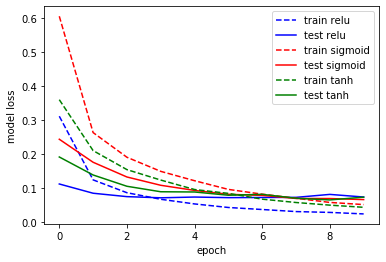

In [11]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'b')
plt.plot(history_sigmoid.history['loss'],'r--')
plt.plot(history_sigmoid.history['val_loss'],'r')
plt.plot(history_tanh.history['loss'],'g--')
plt.plot(history_tanh.history['val_loss'],'g')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train relu', 'test relu','train sigmoid','test sigmoid','train tanh','test tanh'], loc='best')
plt.show()

**Changing the number of neurons:**

In [62]:
model_more_neurons=compile_model(loss=keras.losses.categorical_crossentropy,
                            optimizer=keras.optimizers.Adam(),
                            activation='relu',
                            density=2,
                            intermediate_layers=1,
                            dropout=1)
history_more_neurons=model_more_neurons.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

model_less_neurons=compile_model(loss=keras.losses.categorical_crossentropy,
                            optimizer=keras.optimizers.Adam(),
                            activation='relu',
                            density=1/2,
                            intermediate_layers=1,
                            dropout=1)
history_less_neurons=model_less_neurons.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
938/938 [==============================] - 11s 12ms/step - loss: 0.2446 - accuracy: 0.9264 - val_loss: 0.0994 - val_accuracy: 0.9692
Epoch 2/10
938/938 [==============================] - 11s 12ms/step - loss: 0.1015 - accuracy: 0.9702 - val_loss: 0.0878 - val_accuracy: 0.9748
Epoch 3/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0698 - accuracy: 0.9791 - val_loss: 0.0668 - val_accuracy: 0.9792
Epoch 4/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0501 - accuracy: 0.9844 - val_loss: 0.0717 - val_accuracy: 0.9794
Epoch 5/10
938/938 [==============================] - 11s 11ms/step - loss: 0.0424 - accuracy: 0.9872 - val_loss: 0.0772 - val_accuracy: 0.9782
Epoch 6/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0364 - accuracy: 0.9884 - val_loss: 0.0663 - val_accuracy: 0.9821
Epoch 7/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.0833 - val_accuracy:

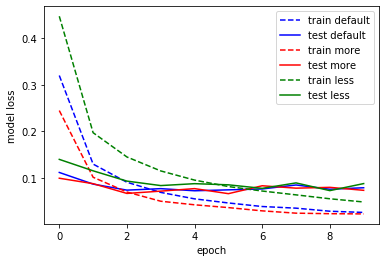

In [65]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'b')
plt.plot(history_more_neurons.history['loss'],'r--')
plt.plot(history_more_neurons.history['val_loss'],'r')
plt.plot(history_less_neurons.history['loss'],'g--')
plt.plot(history_less_neurons.history['val_loss'],'g')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train default', 'test default','train more','test more','train less','test less'], loc='best')
plt.show()

En diminuant le nombre de neurones, on baisse le temps de calcul mais on baisse aussi l'efficacité. En l'augmentant, on augmente le temps de calcul mais le gain d'efficacité ne semble pas significatif (sur le test) 

**Changing the number of layers:**

In [69]:
model_more_layers=compile_model(loss=keras.losses.categorical_crossentropy,
                            optimizer=keras.optimizers.Adam(),
                            activation='relu',
                            density=1,
                            intermediate_layers=4,
                            dropout=1)
history_more_layers=model_more_layers.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

model_less_layers=compile_model(loss=keras.losses.categorical_crossentropy,
                            optimizer=keras.optimizers.Adam(),
                            activation='relu',
                            density=1,
                            intermediate_layers=0,
                            dropout=1)
history_less_layers=model_less_layers.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3141 - accuracy: 0.9079 - val_loss: 0.1160 - val_accuracy: 0.9668
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1234 - accuracy: 0.9669 - val_loss: 0.0905 - val_accuracy: 0.9722
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0881 - accuracy: 0.9763 - val_loss: 0.0923 - val_accuracy: 0.9754
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0666 - accuracy: 0.9817 - val_loss: 0.0901 - val_accuracy: 0.9749
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0550 - accuracy: 0.9850 - val_loss: 0.0857 - val_accuracy: 0.9774
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0482 - accuracy: 0.9866 - val_loss: 0.0895 - val_accuracy: 0.9799
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0410 - accuracy: 0.9891 - val_loss: 0.0957 - val_accuracy: 0.9751
Epoch 

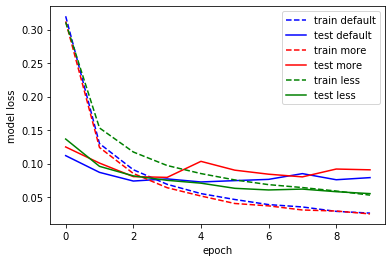

In [68]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'b')
plt.plot(history_more_layers.history['loss'],'r--')
plt.plot(history_more_layers.history['val_loss'],'r')
plt.plot(history_less_layers.history['loss'],'g--')
plt.plot(history_less_layers.history['val_loss'],'g')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train default', 'test default','train more','test more','train less','test less'], loc='best')
plt.show()

**Without Dropout:**

In [70]:
model_no_dropout=compile_model(loss=keras.losses.categorical_crossentropy,
                            optimizer=keras.optimizers.Adam(),
                            activation='relu',
                            density=1,
                            intermediate_layers=1,
                            dropout=0)
history_no_dropout=model_no_dropout.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2159 - accuracy: 0.9370 - val_loss: 0.1009 - val_accuracy: 0.9689
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0842 - accuracy: 0.9738 - val_loss: 0.0810 - val_accuracy: 0.9732
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0545 - accuracy: 0.9825 - val_loss: 0.0735 - val_accuracy: 0.9762
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0394 - accuracy: 0.9876 - val_loss: 0.0812 - val_accuracy: 0.9752
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0297 - accuracy: 0.9904 - val_loss: 0.0705 - val_accuracy: 0.9786
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0259 - accuracy: 0.9915 - val_loss: 0.0933 - val_accuracy: 0.9746
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0195 - accuracy: 0.9935 - val_loss: 0.0787 - val_accuracy: 0.9787
Epoch 

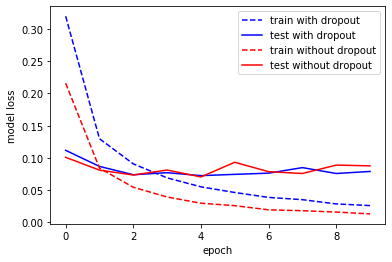

In [72]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'b')
plt.plot(history_no_dropout.history['loss'],'r--')
plt.plot(history_no_dropout.history['val_loss'],'r')

plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train with dropout', 'test with dropout','train without dropout','test without dropout','train less','test less'], loc='best')
plt.show()

## Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. This approach neglects any spatial structure in the image. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [73]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. As we saw in Sec. X of the review, this can be achieved by using convolutional layers. Luckily, all we need to do is change the architecture of our DNN, i.e. introduce small changes to the function `create_model()`. We can also merge **Step 2** and **Step 3** for convenience: 

In [74]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # add second convolutional layer with 20 filters
    model.add(Conv2D(20, (5, 5), activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(20*4*4, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    
    return model

Training the deep conv net (**Step 4**) and evaluating its performance (**Step 6**) proceeds exactly as before:

In [76]:
# training parameters
batch_size = 64
epochs = 10

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history_CNN=model_CNN.fit(X_train, Y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
938/938 [==============================] - 13s 14ms/step - loss: 0.2542 - accuracy: 0.9213 - val_loss: 0.0828 - val_accuracy: 0.9828
Epoch 2/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0912 - accuracy: 0.9711 - val_loss: 0.0598 - val_accuracy: 0.9847
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0706 - accuracy: 0.9782 - val_loss: 0.0426 - val_accuracy: 0.9884
Epoch 4/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0616 - accuracy: 0.9811 - val_loss: 0.0396 - val_accuracy: 0.9894
Epoch 5/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0539 - accuracy: 0.9841 - val_loss: 0.0343 - val_accuracy: 0.9915
Epoch 6/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0491 - accuracy: 0.9851 - val_loss: 0.0310 - val_accuracy: 0.9905
Epoch 7/10
938/938 [==============================] - 14s 14ms/step - loss: 0.0446 - accuracy: 0.9858 - val_loss: 0.0290 - val_accuracy:

Let's compare the results of the CNN and the classic DNN:

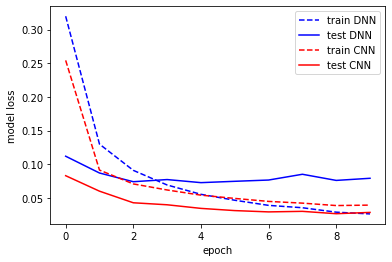

In [77]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'b')
plt.plot(history_CNN.history['loss'],'r--')
plt.plot(history_CNN.history['val_loss'],'r')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train DNN', 'test DNN','train CNN','test CNN'], loc='best')
plt.show()

Le CNN donne de meilleurs resultats que le DNN, ce qui semble cohérent vu qu'il est efficace pour le traitement d'images